In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer 
from typing import Tuple, List, Type, Dict, Any

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Task 1
3-layer Perceptron will have the following architecture:
- 128 nodes in the hidden layer
- tanh() activation function
- softmax() as an output activation function
- cross-entropy loss function

In [3]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.Tanh,
                 num_classes: int = 10):
        
        
        super().__init__()
        
        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation()
        self.num_classes = num_classes
        
        # Layers:
        self.fc1 = torch.nn.Linear(self.input_resolution[0] * self.input_resolution[1], 128)
        self.fc2 = torch.nn.Linear(128, self.num_classes)
        
    def forward(self, X : Type[torch.Tensor]) -> Type[torch.Tensor]:
        
        X = self.fc1(X)
        X = self.activation(X)
        
        X = self.fc2(X)
        output = F.log_softmax(X, dim = 1) # softmax activation function is in the CrossEntropyLoss
        
        return output

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


In [5]:
model = Perceptron()
model.to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (activation): Tanh()
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of trainable parameters 101770


In [6]:
train_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
valid_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

valid_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=valid_transforms)

In [8]:
print('Training set size: {}'.format(len(train_dataset)))
print('Cross-validation set size: {}'.format(len(valid_dataset)))

Training set size: 60000
Cross-validation set size: 10000


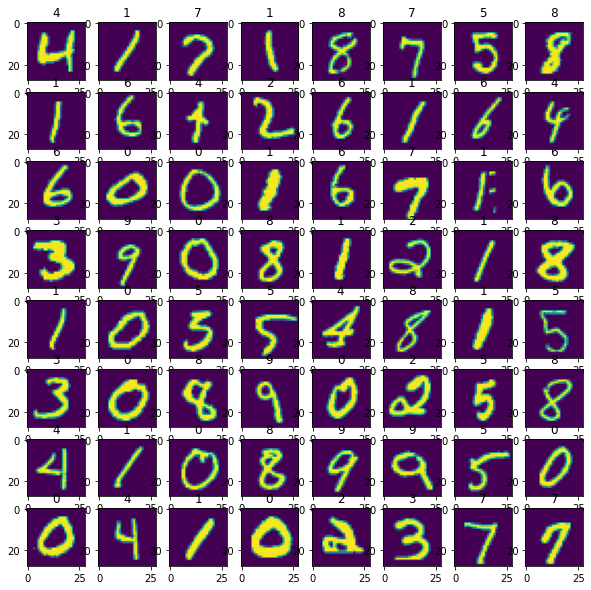

In [9]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title(label)

Training dataset consists of 60000 handwritten digits from _0_ to _9_  
Each training example is a 28x28 gray-scale image of a digit.  
For convenience each image will be reshaped from 28x28 matrix into 28^2 = 784-element row.  
Each pixel has a single pixel-value associated with it,  
indicating the lightness or darkness of that pixel, with higher numbers meaning lighter.

Plot the distribution of the target vectors

In [10]:
def dist_data(dataset, title):
    
    labels = list()
    
    for i in range(0, len(dataset)):
        labels.append(dataset[i][1])
    
    sns.histplot(labels)
    plt.title(title)
    plt.show()

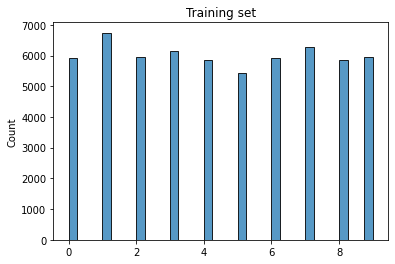

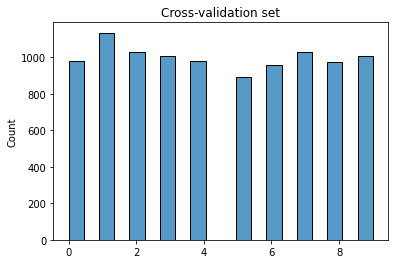

In [11]:
dist_data(train_dataset, 'Training set')
dist_data(valid_dataset, 'Cross-validation set')

In [12]:
train_dataset[132][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

Pixel values lies in the interval [0, 1]. So we should normalize it to _mean = 0_ and _variance = 1_  
Also we'll reshape each sample from _(1, 28, 28)_ to _(1, 784)_  ,  
so dataset will have shape _(m, 784)_, where _m_ is a number of samples

In [13]:
def normalize_and_reshape_data(data):
    
    m = len(data)
    
    for i in range(m):
        pass
        

In [14]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    loss_total = 0
    
    for data in data_loader:
        
        X, y = data
        X, y = X.view(-1, 784), y.to(device)
        X = X.to(device)
        
        model.zero_grad()
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        loss.backward()
        
        optimizer.step()
    
    loss_avg = loss_total / len(data_loader.dataset)
    
    return loss_avg

In [15]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    loss_total = 0
    accuracy_total = 0
    
    for data in data_loader:

        X, y = data
        X, y = X.view(-1, 784), y.to(device)
        X = X.to(device)
        
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        

        y_pred = output.argmax(dim = 1, keepdim=True).to(device)
        accuracy_total += y_pred.eq(y.view_as(y_pred)).sum().item()
        
    loss_avg = loss_total / len(data_loader.dataset)
    accuracy_avg = 100.0 * accuracy_total / len(data_loader.dataset)
    
    return {'loss' : loss_avg, 'accuracy' : accuracy_avg}

In [16]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                valid_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    best_valid_loss = None
    best_epoch = None
    loss_list = {'train' : list(), 'valid' : list()}
    accuracy_list = list()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        
        start = timer()
        
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        
        # Evaluate perfomance on the training set
        loss_list['train'].append(train_loss)
        
        # Evaluate perfomance on the cross-validation set
        valid_metrics = validate_single_epoch(model, loss_function, valid_loader)
        loss_list['valid'].append(valid_metrics['loss'])
        accuracy_list.append(valid_metrics['accuracy'])
        
        print('time:', timer() - start)
        print(f'Validation metrics: \n{valid_metrics}')

        lr_scheduler.step(valid_metrics['loss'])
        
        if best_valid_loss is None or best_valid_loss > valid_metrics['loss']:
            print(f'Best model yet, saving')
            best_valid_loss = valid_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return loss_list, accuracy_list, best_epoch

In [17]:
loss_list, accuracy_list, best_epoch = train_model(model, 
                    train_dataset=train_dataset, 
                    valid_dataset=valid_dataset, 
                    loss_function=torch.nn.CrossEntropyLoss(), 
                    initial_lr=0.01, max_epochs = 500, batch_size = 512)

Epoch 0
time: 12.028210199999997
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.03}
Best model yet, saving
Epoch 1
time: 11.448745900000006
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 96.33}
Best model yet, saving
Epoch 2
time: 12.398520100000006
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 96.78}
Best model yet, saving
Epoch 3
time: 14.628239500000007
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.07}
Best model yet, saving
Epoch 4
time: 16.791741399999992
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.59}
Best model yet, saving
Epoch 5
time: 11.654131399999997
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.29}
Epoch 6
time: 11.080383299999994
Validation metrics: 
{'loss': tensor(0.0002, device='cuda:0'), 'accuracy': 97.25}
Epoch 7
time: 8.318206900000007
Validation metrics: 
{'loss': tensor(0.0002, dev

In [18]:
best_model = torch.load('./best_model.pth')

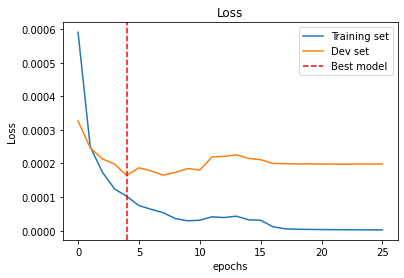

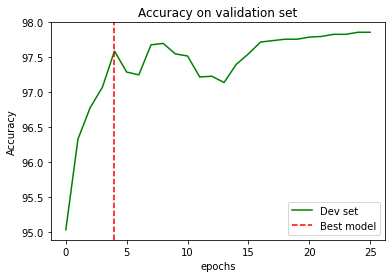

In [20]:
# Plot learning loss curve
plt.plot(loss_list['train'], label = 'Training set')
plt.plot(loss_list['valid'], label = 'Dev set')
plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot accuracy curve         
plt.plot(accuracy_list, color = 'g', label = 'Dev set')
plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
plt.title('Accuracy on validation set')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()